# Machine Learning Application
- Used to help predict Bitcoin price movements using machine learning 
- Sentiment data and technical analysis can help make sense of crypto movements

In [428]:
import numpy as np
import pandas as pd
import quandl
import requests
import os 

import matplotlib.pyplot as plt
%matplotlib inline

import quandl

import plotly.express as px
import plotly.graph_objects as go
import plotly
import seaborn as sns
import panel as pn

In [429]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [430]:
# df = pd.read_csv('/content/drive/MyDrive/Deep Learning Project /Deep-Learning-main/Starter_Code/Data/btc_sentiment_data (1).txt')
# df = df.set_index('date')
# df = df.drop(columns = 'classification')
# df.columns = ['fng_value']
# df = df.dropna()
# df.head()

In [431]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning Project /Deep-Learning-main/Starter_Code/Data/btc_sentiment_data.txt')
df = df.set_index('date')
df = df.drop(columns = 'classification')
df.columns = ['fng_value']
df.head()

,fng_value
date,
05-21-2021,19
05-20-2021,11
05-19-2021,23
05-18-2021,21
05-17-2021,27


In [432]:
# # Load the historical closing prices for Bitcoin
# df2 = pd.read_csv('/content/drive/MyDrive/Deep Learning Project /Deep-Learning-main/Starter_Code/Data/BTC-USD.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
# # df2 = df2[['Last']]
# df2 = df2[['Close']].dropna()
# # df2 = df2[::-1]
# df2.head()

In [433]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('/content/drive/MyDrive/Deep Learning Project /Deep-Learning-main/Starter_Code/Data/bitcoin_price.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df2 = df2[['Last']]
df2.columns = ['Close']
df2.head()

,Close
Date,
2021-05-25,38663.579156
2021-05-24,38349.000000
2021-05-23,34015.471864
2021-05-22,37677.000000
2021-05-21,36795.000000


In [434]:
# df = df.reset_index()
# df2 = df2.reset_index()

In [435]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.sort_index(inplace=True)

In [436]:
# df = df.set_index('Date')
# df = df.drop(columns = ['date'])

In [437]:
df.head()

,fng_value,Close
2018-08-26,19,6687.0
2018-08-27,18,6747.8
2018-08-28,19,7080.1
2018-08-29,19,7052.2
2018-08-30,22,6931.4


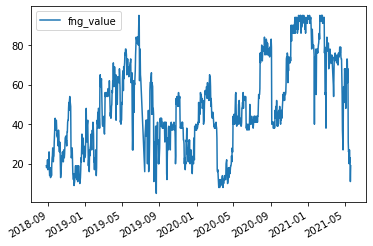

In [438]:
df[['fng_value']].plot()

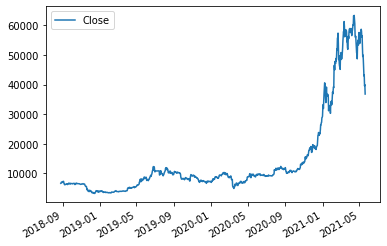

In [439]:
df[['Close']].plot()

In [440]:
df_pct_change = df.pct_change().dropna()
df_pct_change.corr()

,fng_value,Close
fng_value,1.000000,0.033031
Close,0.033031,1.000000


In [441]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [442]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [443]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [444]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [445]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In [446]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [447]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (X_train.shape[1],1))
         )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))


In [448]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")


In [449]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 30)            3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 10, 30)            7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [450]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
epochs = 60
batch_size = 5
model.fit(X_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/60
135/135 [==============================] - 7s 14ms/step - loss: 5.8808e-04
Epoch 2/60
135/135 [==============================] - 2s 15ms/step - loss: 6.9414e-04
Epoch 3/60
135/135 [==============================] - 2s 15ms/step - loss: 9.6457e-04
Epoch 4/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0012
Epoch 5/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0014
Epoch 6/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0013
Epoch 7/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0015
Epoch 8/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0015
Epoch 9/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0016
Epoch 10/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0015
Epoch 11/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0015
Epoch 12/60
135/135 [==============================] - 2s 15ms/step - loss: 0.0015
E

---

## Model Performance

Evaluate model performance 


In [451]:
# Evaluate the model
model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 4ms/step - loss: 0.0023 


0.002290960168465972

In [452]:
# Make some predictions
predicted = model.predict(X_test)

In [453]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [454]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.tail()

,Real,Predicted
2021-05-17,45788.382946,51369.500000
2021-05-18,42930.000000,48775.871094
2021-05-19,43159.000000,45449.761719
2021-05-20,39511.000000,43106.753906
2021-05-21,39954.000000,40439.117188


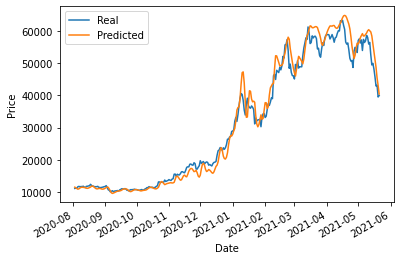

In [455]:
# Plot the real vs predicted values as a line chart
stocks.plot.line(xlabel="Date",
                  ylabel="Price")

In [456]:
# Plot raw index values 
fig = go.Figure()
fig.add_trace(go.Scatter(x=stocks.index, y=stocks['Real'], mode='lines', name='Real Bitcoin Value'))
fig.add_trace(go.Scatter(x=stocks.index, y=stocks['Predicted'], mode='lines', name='Predicted Bitcoin Value'))
fig.update_layout(plot_bgcolor='white', paper_bgcolor='LightSteelBlue')
fig.update_layout(width=1300, height=600)
fig.update_layout(
    title={
        'text': "Algorithm Performance",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
        buttons=list([
            dict(count=12, label="12y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()